In [1]:
#Chinese experimental fast reactor 
import openmc
import numpy as np
import matplotlib as plt


#import the Cross sections file 
openmc.config['cross_sections'] = "/home/f_z/endfb-vii.1-hdf5/cross_sections.xml"

In [2]:
uo2= openmc.Material(material_id=1)
uo2.add_element('U',1, enrichment=5.0)
uo2.add_element ('O',2)
uo2.set_density ('g/cm3', 10.3)

puo2= openmc.Material (material_id=2)
puo2.add_nuclide('Pu239', 0.94)
puo2.add_nuclide('Pu240',0.05)
puo2.add_nuclide('Pu241', 0.01)
puo2.add_element('O',2)
puo2.set_density('g/cm3',11.5)

mox = openmc.Material.mix_materials([uo2,puo2],[0.85,0.15],percent_type='wo')

sodium= openmc.Material(material_id=4)
sodium.add_element('Na',1)
sodium.set_density('g/cm3',0.89)

helium= openmc.Material (material_id=5)
helium.add_element ('He',1)
helium.set_density ('g/cm3',0.0043)

steel= openmc.Material (material_id=6)
steel.add_element('C',0.0005,'wo')
steel.add_element('Ti',0.005,'wo')
steel.add_element ('Cr',0.1625,'wo')
steel.add_element ('Mn',0.02,'wo')
steel.add_element ('Fe',0.65,'wo')
steel.add_element ('Ni',0.14,'wo')
steel.add_element ('Mo',0.022,'wo')
steel.set_density ('g/cm3',7.55)

#we define the blanket material

uo2b= openmc.Material(material_id=7)
uo2b.add_element('U',1, enrichment=0.5)
uo2b.add_element ('O',2)
uo2b.set_density ('g/cm3', 10.3)
#print(uo2,puo2,sodium,helium,steel)
materials= openmc.Materials([mox,uo2b,helium,sodium,steel])
materials.export_to_xml()

In [3]:
#Defining the surfaces of our pellet gap cald.
s_hole = openmc.ZCylinder(0,0,0.075)
s_pellet= openmc.ZCylinder(0,0,0.26)
s_gap= openmc.ZCylinder(0,0,0.275)
s_clad= openmc.ZCylinder(0,0,0.3075)
s_top= openmc.ZPlane(0.5) #boundary_type='reflective')
s_bottom= openmc.ZPlane(-0.5) #boundary_type='reflective')

# The pellet edges are rounded, however, for the sake of simplicity, we will replace them with a 45° bevel.
top_bevel = openmc.ZCone(z0=0.73, r2=1.0)
bottom_bevel = openmc.ZCone(z0=-0.73, r2=1.0)


#adding the ones for the fuel rod (only horizontal planes)
                        
#under the pellets:
s_top_lower_blanket= openmc.ZPlane(-21.5)
s_bottom_lower_blanket= openmc.ZPlane(-47.5)
s_top_bottom_plug= openmc.ZPlane(-94.0)
s_bottom_bottom_plug= openmc.ZPlane(-96.0,boundary_type='reflective')

#over the pellets

s_bottom_upper_blanket=openmc.ZPlane(+21.5)
s_bottom_upper_blanket= openmc.ZPlane(+21.5)
s_top_upper_blanket=openmc.ZPlane(+32.5)
s_bottom_top_plug= openmc.ZPlane(+37.5)
s_top_top_plug= openmc.ZPlane(+39,boundary_type='reflective')                



In [4]:
#we define the cells

#hole
c_hole = openmc.Cell (name= 'central hole')
c_hole.region = -s_hole & -s_top & +s_bottom
c_hole.fill= helium

#pellet
c_pellet = openmc.Cell (name= 'pellet')
c_pellet.region = -s_top & +s_bottom & -s_pellet & +s_hole
c_pellet.fill= mox

#gap
c_gap = openmc.Cell (name= 'gap')
c_gap.region =  +s_pellet & -s_top & +s_bottom #&-s_gap
c_gap.fill= helium

'''clad (was necessary for the pellet) 
c_clad = openmc.Cell (name= 'clad')#c_clad.region = +s_gap & -s_clad & -s_top & +s_bottom
c_clad.fill= steel

#Now we have to add the coolant which has an exagonal shape around the pin

c_sodium = openmc.Cell (name= 'gap')
c_sodium.region = +s_clad & -s_top & +s_bottom
c_sodium.fill= sodium'''
#we define a universe filled with this geometry, then it will be a metter to fill an exagonal shape with our universe

pellet_universe= openmc.Universe (cells=[c_hole,c_pellet,c_gap])#,c_clad,c_sodium])


#we now define instead the pellet stack in the fuel cell

pellet_stack =openmc.RectLattice (name='pellet stack')
pellet_stack.pitch= (1.0,1.0,1.0)  #size along the three direction
#we define th most negative corner of the lattice (like a parallelepipedo)
pellet_stack.lower_left= [-0.5,-0.5,-21.5] 
pellet_stack.universes= [[[pellet_universe]]]*43

#pellet stack
c_pellet_stack= openmc.Cell(name='Stack cell')
c_pellet_stack.region= +s_top_lower_blanket & -s_bottom_upper_blanket
c_pellet_stack.fill= pellet_stack

#under the pellets

#lower blanket
c_lower_blanket= openmc.Cell(name='Lower Blanket')
c_lower_blanket.region=  -s_top_lower_blanket & + s_bottom_lower_blanket
c_lower_blanket.fill= uo2b
#bottom gas plenum
c_bottom_gas= openmc.Cell(name='Bottom gas plenum')
c_bottom_gas.region=  +s_top_bottom_plug & - s_bottom_lower_blanket
c_bottom_gas.fill= helium
#bottom plug
c_bottom_plug= openmc.Cell(name='Bottom plug')
c_bottom_plug.region=  -s_top_bottom_plug #& + s_bottom_bottom_plug (we cut later)
c_bottom_plug.fill= steel

#over the pellets

#upper blanket
c_upper_blanket= openmc.Cell(name='upper Blanket')
c_upper_blanket.region=  -s_top_upper_blanket & + s_bottom_upper_blanket
c_upper_blanket.fill= uo2b
#top gas plenum
c_top_gas= openmc.Cell(name='top gas plenum')
c_top_gas.region=  -s_bottom_top_plug & + s_top_upper_blanket
c_top_gas.fill= helium
#top plug
c_top_plug= openmc.Cell(name='top plug')
c_top_plug.region=  +s_bottom_top_plug #& + s_top_top_plug (we cut later)
c_top_plug.fill= steel

#pellet_universe.plot(basis='xy', width=(1,1), color_by='material')

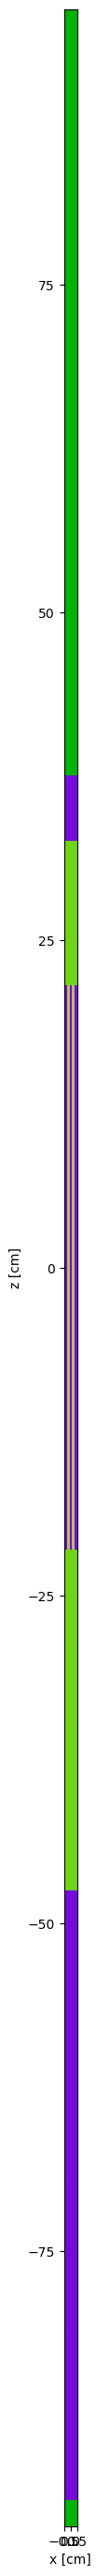

In [5]:
#we create a universe with these cells

inclad_universe= openmc.Universe(cells=[c_bottom_plug,c_bottom_gas, c_lower_blanket,c_pellet_stack, c_upper_blanket,c_top_gas,c_top_plug])
inclad_universe.plot(basis='xz', width=(1.0,192), color_by='material')
#
inclad= openmc.Cell(name='Components inside the cladding')
inclad.region= - s_top_top_plug & +s_bottom_bottom_plug &-s_gap
inclad.fill= inclad_universe

#clad  
c_clad = openmc.Cell (name= 'clad')
c_clad.region = +s_gap & -s_clad & -s_top_top_plug & +s_bottom_bottom_plug
c_clad.fill= steel

#Now we have to add the coolant which has an exagonal shape around the pin

c_sodium = openmc.Cell (name= 'gap')
c_sodium.region = +s_clad & -s_top_top_plug & +s_bottom_bottom_plug
c_sodium.fill= sodium

fuel_rod_universe=openmc.Universe(cells=[inclad,c_clad,c_sodium]) 



In [6]:
#we now define the coolant exagonal cell

pitch = 0.715
edge= (pitch/2)/ np.sin(np.pi/3)
hex_cell = openmc.model.HexagonalPrism(edge_length=edge)#boundary_type='reflective')

#let's fill the hexagon with  our cell
c_fuel_rod= openmc.Cell(name='fuel rod')
c_fuel_rod.region= -hex_cell & +s_bottom_bottom_plug & -s_top_top_plug
c_fuel_rod.fill = fuel_rod_universe
#
#fuel_rod_universe = openmc.Universe(cells=[c_fuel_rod])
#fuel_rod_universe.plot(basis='xz',width=(1.0,192.0), color_by= 'material',origin =[0,0,0])

In [7]:
#we export the geometry as an Xml
fuel_cell_geometry =openmc.Geometry(fuel_rod_universe)
fuel_cell_geometry.export_to_xml()
#!cat geometry.xml


#we can now use the geometry to calculate the so called "tallies"
#those will have all the same structure:
#triple integrale over (E,angle,r) multiplied by the flux


#let's define the "filters"
#in the parentesis we have the energy groups in Ev (0-->0.68; 0.68-->20*10^6)
e_filter=openmc.EnergyFilter([0.0,0.68,20e6])
#filter for the spatial information (discretization)
msh_filter=openmc.RegularMesh(mesh_id=1)
msh_filter.dimension=(25,25,1)
#we define the most negative and positive point creating a parallelepide that comprehends everything
msh_filter.lower_left=([-pitch/2,-edge,-0.5])
msh_filter.upper_right=[pitch/2,edge,0.5]
mesh_filter= openmc.MeshFilter(msh_filter)#,filter_id=1) 

#let's calculate tallies!!

flux= openmc.Tally(tally_id=1,name= 'Flux')
flux.scores= ['flux']
flux.filters= [e_filter, mesh_filter]
#
fission_rr =openmc.Tally (tally_id=2,name='Fission reaction rate')
fission_rr.scores = ['fission']
fission_rr.filters = [e_filter, mesh_filter]
#
tallies = openmc.Tallies([flux,fission_rr])
tallies.export_to_xml()

In [8]:
#we have now to define the number of generations of neutrons. Particularly we will
#define a numeber of inactive cycles that will not be counted so that we reach the
#fundamental harmonic. If the inactive number is great enough aumenting it shouldn't have any 
#effect on the calculation

source_point= openmc.stats.Point(xyz=(0.0,0.0,0.0))
source_region= openmc.stats.Box((-0.3075,-0.3075,-0.5),(0.3075,0.3075,0.5))
source_energy= openmc.stats.Watt( a=988000.0,b=2.249e-06)
source1 = openmc.Source(space=source_point,energy=source_energy)
source2 = openmc.Source(space=source_region,energy=source_energy)
#we are performing a criticality calculation, for this reason we impose 5000 neutrons for each batch
sim_settings= openmc.Settings()
sim_settings.run_mode='eigenvalue'
sim_settings.particles =5000
sim_settings.inactive=10
sim_settings.batches=25
sim_settings.source= source1
#we export also the simulation settings in te xml file
sim_settings.export_to_xml()
#!cat settings.xml


/home/f_z/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/source.py:656: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [9]:
#openmc.run()

3.3486315612998294 3.48719562590534
                              (0, 0)
                        (0,29)      (0, 1)
                  (0,28)      (1, 0)      (0, 2)
            (0,27)      (1,23)      (1, 1)      (0, 3)
      (0,26)      (1,22)      (2, 0)      (1, 2)      (0, 4)
(0,25)      (1,21)      (2,17)      (2, 1)      (1, 3)      (0, 5)
      (1,20)      (2,16)      (3, 0)      (2, 2)      (1, 4)
(0,24)      (2,15)      (3,11)      (3, 1)      (2, 3)      (0, 6)
      (1,19)      (3,10)      (4, 0)      (3, 2)      (1, 5)
(0,23)      (2,14)      (4, 5)      (4, 1)      (2, 4)      (0, 7)
      (1,18)      (3, 9)      (5, 0)      (3, 3)      (1, 6)
(0,22)      (2,13)      (4, 4)      (4, 2)      (2, 5)      (0, 8)
      (1,17)      (3, 8)      (4, 3)      (3, 4)      (1, 7)
(0,21)      (2,12)      (3, 7)      (3, 5)      (2, 6)      (0, 9)
      (1,16)      (2,11)      (3, 6)      (2, 7)      (1, 8)
(0,20)      (1,15)      (2,10)      (2, 8)      (1, 9)      (0,10)
      (0,19)

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

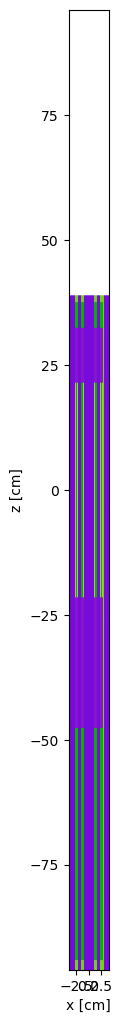

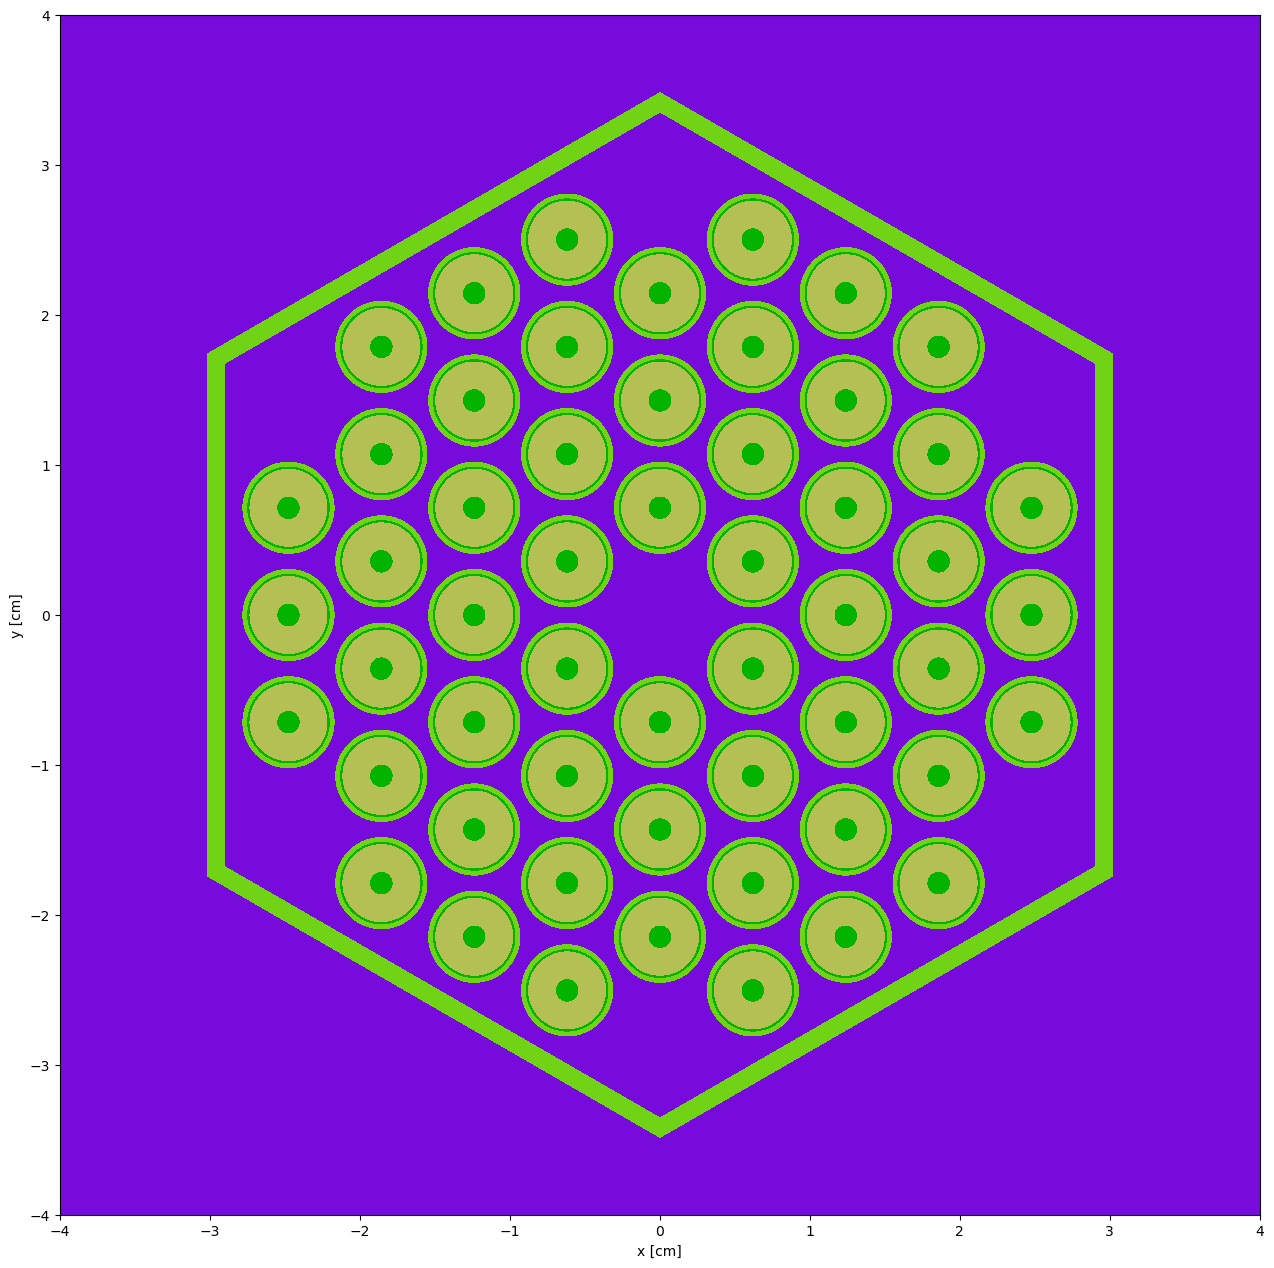

In [10]:
#We can finally define the bundle made of cells!

#(1) we define the walls of the bundle (two exagonal cells)

in_edge= (5.8/2)/ np.sin(np.pi/3)
out_edge= (6.04/2)/ np.sin(np.pi/3)
print (in_edge, out_edge)
hex_in_bundle  = openmc.model.HexagonalPrism(edge_length=in_edge,orientation='y')
hex_out_bundle = openmc.model.HexagonalPrism(edge_length=out_edge) #,boundary_type='reflective')

#(2) we define the lattice
bundle_lat= openmc.HexLattice(name='bundle lattice')
bundle_lat.center=(0.0,0.0)
#pitch (along x, along z)
bundle_lat.pitch= (0.715,)
#bundle_lat.num_rings= 

#(3) we create the outer universe of the lattice which is not confined into surfaces since it will be inside the one created in (1)
all_sodium= openmc.Cell(name='All sodium')
all_sodium.fill= sodium

infinite_sodium= openmc.Universe(cells= [all_sodium])

bundle_lat.outer= infinite_sodium



ring0=[infinite_sodium,fuel_rod_universe,fuel_rod_universe,fuel_rod_universe]*6
ring1=[fuel_rod_universe]*18
ring2=[fuel_rod_universe]*12
ring3=[fuel_rod_universe]*6
ring4=[infinite_sodium]*1

bundle_lat.universes =[ring0, ring1, ring2, ring3, ring4]

print (bundle_lat.show_indices(num_rings=6))
#print (bundle_lat)


#
c_bundle_lat= openmc.Cell(name= 'Bundle lattice cell')
c_bundle_lat.region= -hex_in_bundle & +s_bottom_bottom_plug & -s_top_top_plug
c_bundle_lat.fill= bundle_lat

#
c_bundle_box= openmc.Cell(name ='bundle box')
c_bundle_box.region= -hex_out_bundle & +hex_in_bundle & +s_bottom_bottom_plug & -s_top_top_plug
c_bundle_box.fill= steel

#
c_bundle_outer= openmc.Cell(name='bundle outer sodium')
c_bundle_outer.region= +hex_out_bundle &  +s_bottom_bottom_plug & -s_top_top_plug
c_bundle_outer.fill= sodium
#
bundle_universe= openmc.Universe (cells= [c_bundle_box,c_bundle_lat,c_bundle_outer])
bundle_universe.plot(basis='xz',width=(8,192), color_by= 'material',origin =[0,0,0])
bundle_universe.plot(basis='xy',width=(8,8),pixels=(1200,1200), color_by= 'material',origin =[0,0,0])

In [11]:
#we export the bundle asa geometry (Xml)
bundle_geometry= openmc.Geometry(bundle_universe)
bundle_geometry.export_to_xml()
!cat geometry.xml

<?xml version='1.0' encoding='UTF-8'?>
<geometry>
  <cell id="1" material="5" name="central hole" region="-1 -5 6" universe="1"/>
  <cell id="2" material="3" name="pellet" region="-5 6 -2 1" universe="1"/>
  <cell id="3" material="5" name="gap" region="2 -5 6" universe="1"/>
  <cell fill="2" id="4" name="Stack cell" region="9 -14" universe="3"/>
  <cell id="5" material="7" name="Lower Blanket" region="-9 10" universe="3"/>
  <cell id="6" material="5" name="Bottom gas plenum" region="11 -10" universe="3"/>
  <cell id="7" material="6" name="Bottom plug" region="-11" universe="3"/>
  <cell id="8" material="7" name="upper Blanket" region="-15 14" universe="3"/>
  <cell id="9" material="5" name="top gas plenum" region="-16 15" universe="3"/>
  <cell id="10" material="6" name="top plug" region="16" universe="3"/>
  <cell fill="3" id="11" name="Components inside the cladding" region="-17 12 -3" universe="4"/>
  <cell id="12" material="6" name="clad" region="3 -4 -17 12" universe="4"/>
  <cell

In [12]:
#we can now use the geometry to calculate the so called "tallies"
#those will have all the same structure:
#triple integrale over (E,angle,r) multiplied by the flux


#let's define the "filters"
#in the parentesis we have the energy groups in Ev (0-->0.68; 0.68-->20*10^6)
e_filter=openmc.EnergyFilter([0.0,1000,20e6])
#filter for the spatial information (discretization)
msh_filter=openmc.RegularMesh(mesh_id=1)
msh_filter.dimension=(250,250,1)
#we define the most negative and positive point creating a parallelepide that comprehends everything
#we define the most negative and the most positive corner
msh_filter.lower_left= [-out_edge*np.cos(np.pi/6),-out_edge,-0.5]
msh_filter.upper_right= [out_edge*np.cos(np.pi/6),out_edge,0.5]
mesh_filter= openmc.MeshFilter(msh_filter)#,filter_id=1) 

#let's calculate tallies!!

flux= openmc.Tally(tally_id=1,name= 'Flux')
flux.scores= ['flux']
flux.filters= [e_filter, mesh_filter]
#
fission_rr =openmc.Tally (tally_id=2,name='Fission reaction rate')
fission_rr.scores = ['fission']
fission_rr.filters = [e_filter, mesh_filter]
#
tallies = openmc.Tallies([flux,fission_rr])
tallies.export_to_xml()
#!cat.tallies.xml

/home/f_z/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=1.
  warn(msg, IDWarning)
/home/f_z/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Tally instance already exists with id=1.
  warn(msg, IDWarning)
/home/f_z/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Tally instance already exists with id=2.
  warn(msg, IDWarning)


In [13]:
#we have now to define the number of generations of neutrons. Particularly we will
#define a numeber of inactive cycles that will not be counted so that we reach the
#fundamental harmonic. If the inactive number is great enough aumenting it shouldn't have any 
#effect on the calculation

source_point= openmc.stats.Point(xyz=(0.0,0.0,0.0))
#we define a parallelepipedo box inside teh bundle
#this represents only where the starting gen of neutrons will appear
#this will not affect the calculations results but only the convergence speed
source_region= openmc.stats.Box((-1.5,-1.5,-21.5),(1.5,1.5,21.5))
source_energy= openmc.stats.Watt( a=988000.0,b=2.249e-06)
source1 = openmc.Source(space=source_point,energy=source_energy)
source2 = openmc.Source(space=source_region,energy=source_energy)
#we are performing a criticality calculation, for this reason we impose 50000 neutrons for each batch
sim_settings= openmc.Settings()
sim_settings.run_mode='eigenvalue'
sim_settings.particles =50000
sim_settings.inactive=10
sim_settings.batches=25
sim_settings.source= source1
#we export also the simulation settings in te xml file
sim_settings.export_to_xml()
#!cat settings.xml


/home/f_z/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/source.py:656: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [14]:
#openmc.run()

In [15]:
#we now load the statepoint file obtained which contains our results
#sp_file=openmc.StatePoint('s.file.25.10')


In [16]:
#WE DEFINE THE CORE

bundle_pitch= 6.04+0.4
core_lat= openmc.HexLattice(name='core lattice')
core_lat.center=(0.0,0.0)
core_lat.orientation='x'
#pitch (along x, along z)
core_lat.pitch= (bundle_pitch,)
#bundle_lat.num_rings= 

all_sodium= openmc.Cell(name='All sodium')
all_sodium.fill= sodium

infinite_sodium= openmc.Universe(cells= [all_sodium])

core_lat.outer= infinite_sodium
(bundle_lat.show_indices(num_rings=10))

cring_10= ([infinite_sodium]*2 +[bundle_universe]*6 +[infinite_sodium])*6
cring_9=[bundle_universe]*48
cring_8=[bundle_universe]*42
cring_7=[bundle_universe]*36
cring_6=[bundle_universe]*30
cring_5=[bundle_universe]*24
cring_4=[bundle_universe]*18
cring_3=[bundle_universe]*12
cring_2=[bundle_universe]*6
cring_1=[bundle_universe]*1

core_lat.universes =[cring_10,cring_9,cring_8,cring_7,cring_6,cring_5,cring_4,cring_3,cring_2,cring_1]

print(core_lat)

HexLattice
	ID             =	8
	Name           =	core lattice
	Orientation    =	x
	# Rings        =	10
	# Axial        =	None
	Center         =	(0.0, 0.0)
	Pitch          =	(6.44,)
	Outer          =	9
	Universes      
         9 9 7 7 7 7 7 7 9 9
        9 7 7 7 7 7 7 7 7 7 9
       7 7 7 7 7 7 7 7 7 7 7 7
      7 7 7 7 7 7 7 7 7 7 7 7 7
     7 7 7 7 7 7 7 7 7 7 7 7 7 7
    7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
   7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
  7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 9 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 9
9 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 9
 9 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 9
  7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
   7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
    7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
     7 7 7 7 7 7 7 7 7 7 7 7 7 7
      7 7 7 7 7 7 7 7 7 7 7 7 7
       7 7 7 7 7 7 7 7 7 7 7 7
        9 7 7 7 7 7 7 7 7 7 9
         9 9 7 7 7 7 7 7 9 9


<Axes: xlabel='x [cm]', ylabel='y [cm]'>

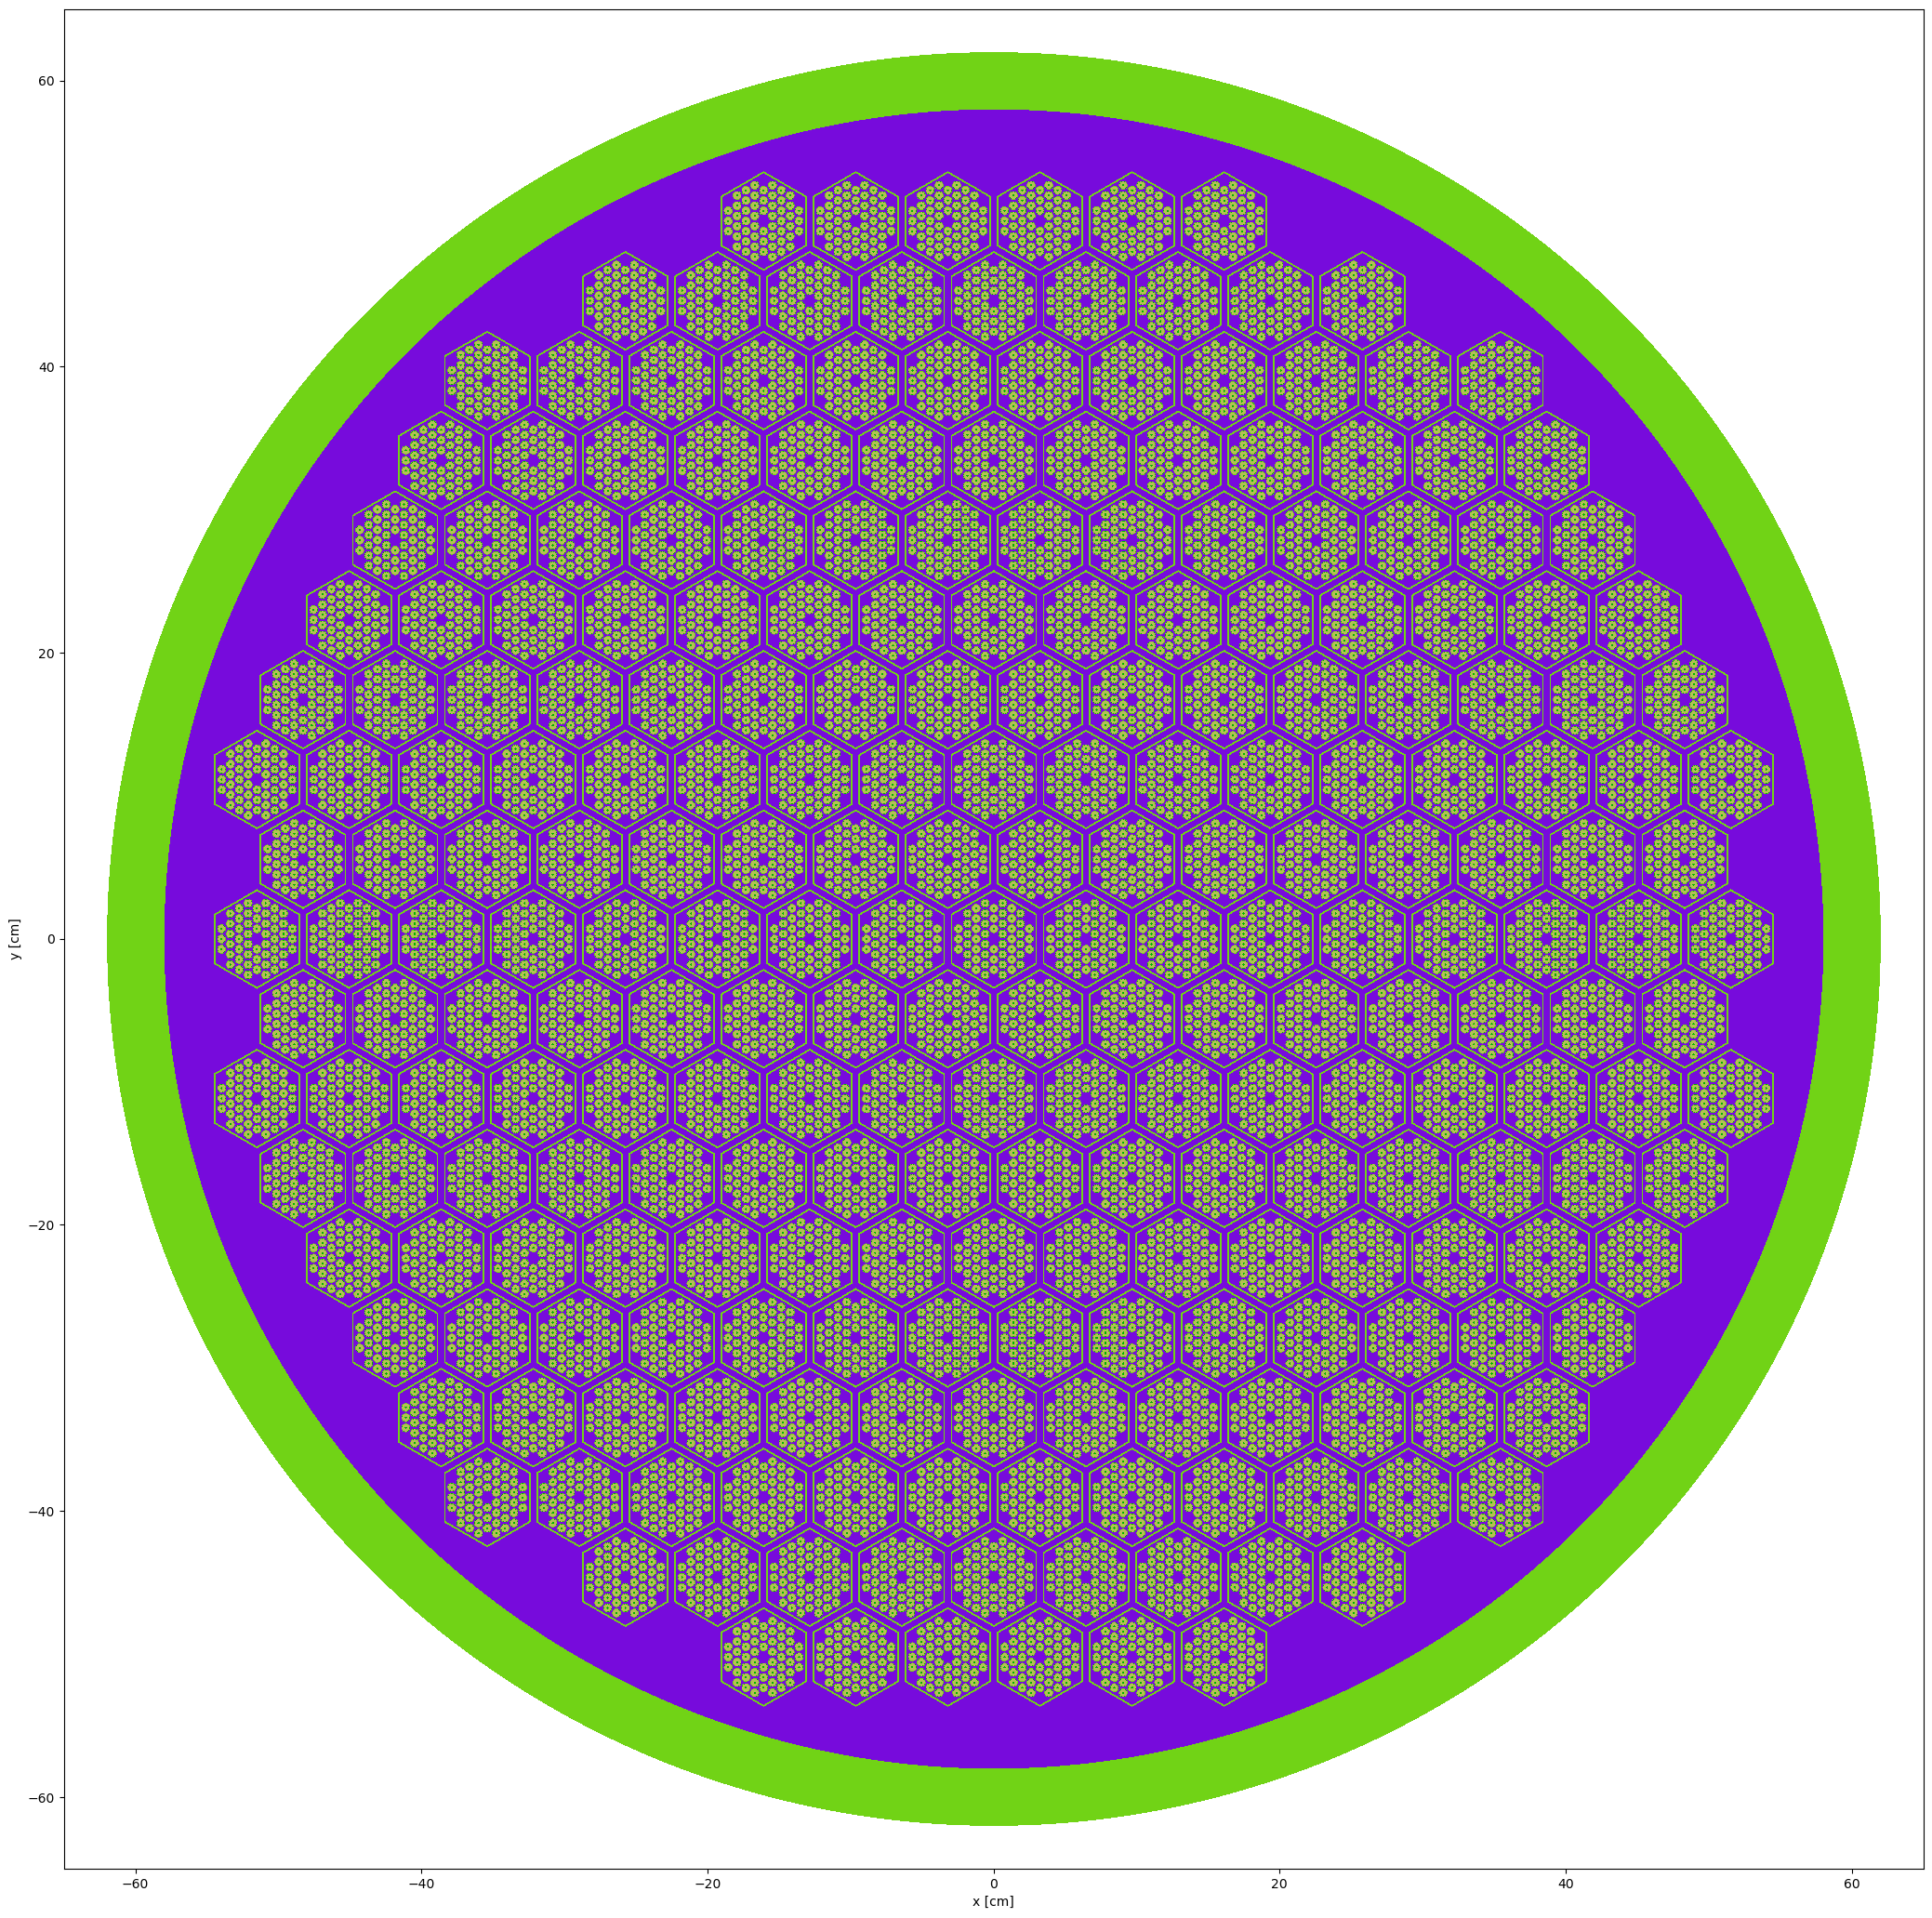

In [20]:
#WE NOW DEFINE THE EXTERNAL PART
barrel_in= openmc.ZCylinder(r=58.0)
barrel_out=openmc.ZCylinder(r=62.0,boundary_type='vacuum')

#CORE REGION
c_core= openmc.Cell()
c_core.region=-barrel_in &  +s_bottom_bottom_plug & -s_top_top_plug
c_core.fill= core_lat

#CORE BARREL
c_barrel= openmc.Cell()
c_barrel.region= +barrel_in & -barrel_out &  +s_bottom_bottom_plug & -s_top_top_plug
c_barrel.fill= steel

#WE CREATE THE UNIVERSE TO BE PLOTTED
reactor_universe= openmc.Universe (cells=[c_core,c_barrel])

#we can now plot

reactor_universe.plot(basis='xy',width=(130,130), pixels =(2000,2000),color_by= 'material',origin =[0,0,0])


In [18]:
source_point= openmc.stats.Point(xyz=(0.0,0.0,0.0))
#we define a parallelepipedo box inside teh bundle
#this represents only where the starting gen of neutrons will appear
#this will not affect the calculations results but only the convergence speed
source_region= openmc.stats.Box((-1.5,-1.5,-21.5),(1.5,1.5,21.5))
source_energy= openmc.stats.Watt( a=988000.0,b=2.249e-06)
source1 = openmc.Source(space=source_point,energy=source_energy)
source2 = openmc.Source(space=source_region,energy=source_energy)
#we are performing a criticality calculation, for this reason we impose 50000 neutrons for each batch
sim_settings= openmc.Settings()
sim_settings.run_mode='eigenvalue'
sim_settings.particles =50000
sim_settings.inactive=10
sim_settings.batches=25
sim_settings.source= source1
#we export also the simulation settings in te xml file
sim_settings.export_to_xml()
#!cat settings.xml

/home/f_z/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/source.py:656: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [19]:

#we can now use the geometry to calculate the so called "tallies"
#those will have all the same structure:
#triple integrale over (E,angle,r) multiplied by the flux


#let's define the "filters"
#in the parentesis we have the energy groups in Ev (0-->0.68; 0.68-->20*10^6)
e_filter=openmc.EnergyFilter([0.0,100,20e6])
#filter for the spatial information (discretization)
msh_filter=openmc.RegularMesh(mesh_id=1)
msh_filter.dimension=(25,25,1)
#we define the most negative and positive point creating a parallelepide that comprehends everything
msh_filter.lower_left=([-pitch/2,-edge,-0.5])
msh_filter.upper_right=[pitch/2,edge,0.5]
mesh_filter= openmc.MeshFilter(msh_filter)#,filter_id=1) 

#let's calculate tallies!!

flux= openmc.Tally(tally_id=1,name= 'Flux')
flux.scores= ['flux']
flux.filters= [e_filter, mesh_filter]
#
fission_rr =openmc.Tally (tally_id=2,name='Fission reaction rate')
fission_rr.scores = ['fission']
fission_rr.filters = [e_filter, mesh_filter]
#
tallies = openmc.Tallies([flux,fission_rr])
tallies.export_to_xml()

/home/f_z/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=1.
  warn(msg, IDWarning)
/home/f_z/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Tally instance already exists with id=1.
  warn(msg, IDWarning)
/home/f_z/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Tally instance already exists with id=2.
  warn(msg, IDWarning)
